# Exploring the Learning Rate Survey

In this notebook we'll take a look at the learning rate survey (a.k.a the LR range test from [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186).
The paper describes the LR range test as follows:

> run your model for several epochs while letting the learning rate increase linearly between low and high LR values.

We instead will increase the learning rate exponentially so that we can evaluate a larger range of values.

> Next, plot the accuracy versus learning rate. Note the learning rate value when the accuracy starts to increase and when the accuracy slows, becomes ragged, or starts to fall. These two learning rates are good choices for bounds

And while the paper's authors choose to plot *Classification Accuracy* vs *Learning Rate*, we instead show *Training Loss*.
This choice makes sense because you'll always have a *Training Loss* (for any supervised learning application at least), but you might not have a *Classification Accuracy* to evaluate.

In this notebook we will
  * take a look at how consistent learning rate surveys are from run to run.
  * see that a survey using the MNIST dataset is qualitatively different from a survey using FashionMNIST dataset.
  * explore changing the duration of surveys.
  * investigate the effect of increasing batch size on learning rate surveys.
  
In other notebooks we take a look at how the survey results compare to grid learning rate searches, and how cyclical learning rates compare to constant and piecewise-constant learning rates.

## Setup -- Building the Model and Trainer

In [1]:
from matplotlib import pyplot as plt
from sconce.data_generator import DataGenerator
from sconce.models import BasicClassifier
from sconce.trainers import ClassifierTrainer
from torch import optim
from torchvision import datasets

import sconce
import torch

print(f'Sconce Version: {sconce.__version__}')

def get_trainer(dataset_class=datasets.MNIST, batch_size=500):
    model = BasicClassifier.new_from_yaml_filename('basic_classifier_MNIST.yaml')

    training_generator = DataGenerator.from_pytorch(batch_size=batch_size,
                                                    dataset_class=dataset_class)
    test_generator = DataGenerator.from_pytorch(batch_size=batch_size,
                                                dataset_class=dataset_class,
                                                train=False)

    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()

    optimizer = optim.SGD(model.parameters(), lr=1e-2,
            momentum=0.9, weight_decay=1e-4)

    trainer = ClassifierTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

trainer = get_trainer()

Sconce Version: 0.3.1


## Single Learning Rate Survey

Let's carry out a learning rate survey, training the model for 1 epoch with a learning rate that rises exponentially from 1e-4 up to 10.
If the *Training Loss* rises above 3x it's lowest value, we will stop early.

112/120 [===========================>..] - ETA: 0s - loss: 1.8827

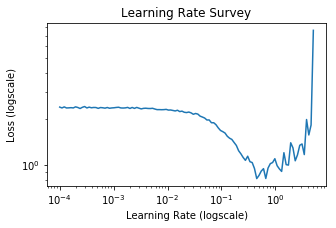

In [2]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey(figure_kwargs={'figsize': (5, 3)});

## Run to Run Survey Variability

To get an idea of how reproducible the learning rate survey is, let's do 10 of them and view them all.
In the first plot below you'll see variability related to shuffling the training samples, and variablity from [SurfaceConvolutions](https://discuss.pytorch.org/t/non-determinisic-results/459/5) performed by CuDNN.
The learning rate survey shows quite a lot of stability, up until about LR=2e-1 where variablity increases gradually until the loss diverges above LR=2 or so.

In the second plot, we also reinitialize the model's starting parameters which increases the variability some but not much.
Overall the learning rate survey seems pretty reproducible.

106/120 [=========================>....] - ETA: 0s - loss: 1.9010

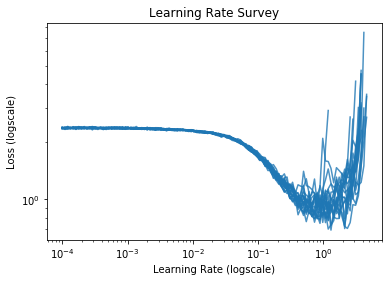

In [3]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
for i in range(20):
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, color='#1f77b4', alpha=0.8);

111/120 [==========================>...] - ETA: 0s - loss: 1.8557

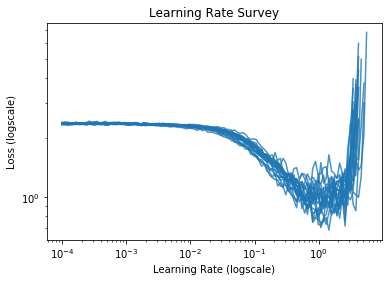

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
for i in range(20):
    trainer = get_trainer()
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, color='#1f77b4', alpha=0.8);

## MNIST vs FashionMNIST Surveys

Below we plot learning rate surveys using different datasets.
It is clear that training a classifier on the FashionMNIST dataset will be different from training the same model on the MNIST dataset.
The survey indicates that the loss will not fall as fast (FashionMNIST is harder to classify than MNIST).
Smaller learning rates appear to lower the loss more effectively for FashionMNIST relative to regular MNIST.
Also, the survey shows that for high learning rates FashionMNIST is much more likely to diverge during training than MNIST.

109/120 [==========================>...] - ETA: 0s - loss: 2.0175

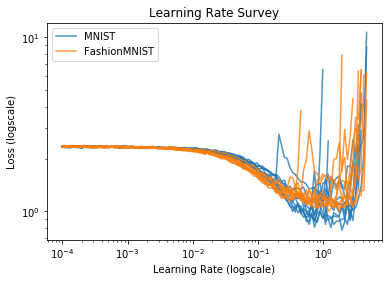

In [5]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
for i in range(10):
    trainer = get_trainer()
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax,
        label='MNIST', color='#1f77b4', alpha=0.8);
for i in range(10):
    trainer = get_trainer(dataset_class=datasets.FashionMNIST)
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax,
        label='FashionMNIST', color='#ff7f0e', alpha=0.8)
ax.legend();

## Survey Duration

In [the cyclical learning rate paper](http://arxiv.org/abs/1506.01186), they suggest running the LR range test for 8 epochs or so.
Let's see how the survey changes as we adjust the duration.

As expected, the loss begins to drop earlier when the survey includes more training steps (longer duration).
The minimum value of the loss is lower for longer duration surveys, again due to the increase in the number of training updates to the model parameters.
Importantly though, it appears that the divergence occurs consistently above LR=2 regardless of the survey duration.
It's hard to say if the minimum shifts significantly, perhaps but not much.

543/600 [==========================>...] - ETA: 1s - loss: 1.4242

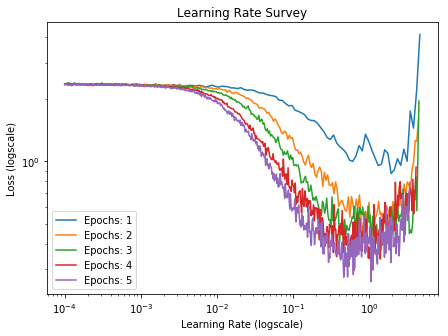

In [6]:
trainer = get_trainer()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
for i in range(1, 6):
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=i, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, label=f'Epochs: {i}')
ax.legend();

## Effect of Batch Size on Surveys

Various papers such as [Large Batch Training of Convolutional Networks](http://arxiv.org/abs/1708.03888) and [DON'T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE](https://arxiv.org/pdf/1711.00489.pdf) suggest that the batch size is another important hyperparameter to explore.
How does the learning rate survey change with increasing batch size?

56/60 [===========================>..] - ETA: 0s - loss: 2.1324

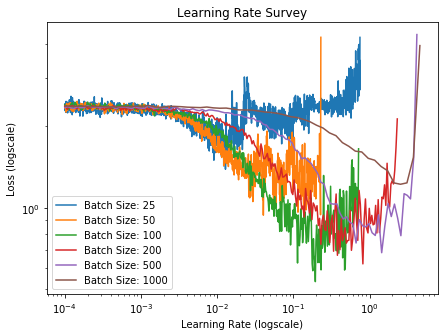

In [7]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
for bs in [25, 50, 100, 200, 500, 1000]:
    trainer = get_trainer(batch_size=bs)
    
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=1, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, label=f'Batch Size: {bs}')
ax.legend();

The above plot shows some interesting changes are occuring with increasing batch size, but it's hard to disentangle them with the differences due to having more training steps in the sample.
Below we fix the number of training steps per sample and it becomes more clear what the effects of increased batch size are.
Consistent with the conclusions of the papers mentioned above, the survey reveals that the higher learning rates can be used when the batch size is larger.
It also shows that below a certain batch size, the normalizing effect of small batch sizes overwhelms training even at low learning rates and the model becomes untrainable.

286/300 [===========================>..] - ETA: 0s - loss: 1.5163

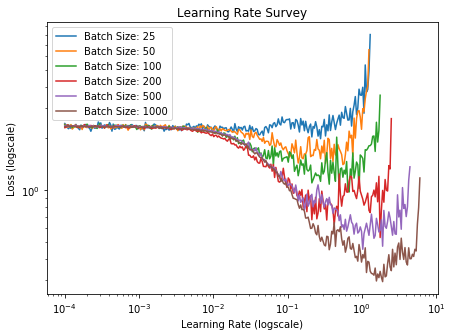

In [8]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
for bs in [25, 50, 100, 200, 500, 1000]:
    trainer = get_trainer(batch_size=bs)

    num_epochs = bs / 200
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=num_epochs, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, label=f'Batch Size: {bs}')
ax.legend();